BLG 307 - YAPAY ZEKA SİSTEMLERİ PROJE TESLİMİ:

Adınız: Ali

Soyadınız: Uçma

Okul Numaranız: 2212721007

GitHub Repo Bağlantısı: https://github.com/Alu0320/genetik_optimizasyon



In [12]:
import random
import matplotlib.pyplot as plt

In [13]:
# Problem Değişken Aralıkları
X1_MIN, X1_MAX = 10.0, 80.0     # Reaktif A (%)
X2_MIN, X2_MAX = 10.0, 80.0     # Reaktif B (%)

In [14]:
# Genetik Algoritma Parametreleri
POP_SIZE = 30               # Popülasyon büyüklüğü
N_GENERATIONS = 50          # Toplam nesil sayısı
CROSSOVER_RATE = 0.8        # Çaprazlama olasılığı
MUTATION_RATE = 0.2         # Mutasyon olasılığı
TOURNAMENT_SIZE = 3         # Turnuva seçim boyutu

In [15]:
def objective(x1, x2):
    """
    Amaç Fonksiyonu: y = 3x₁ + 2x₂ + x₁x₂ - 0.5x₂²
    """
    return 3*x1 + 2*x2 + (x1*x2) - 0.5*(x2**2)

In [16]:
def is_feasible(x1, x2):
    """
    Çözüm kısıtlara uyuyor mu kontrolü.
    Kısıtlar:
    1. x1 >= 25
    2. x1 + x2 <= 100
    3. Aralıklar [10, 80]
    """
    if x1 < 25: return False
    if (x1 + x2) > 100: return False
    if not (X1_MIN <= x1 <= X1_MAX): return False
    if not (X2_MIN <= x2 <= X2_MAX): return False
    return True

def repair(ind):
    """
    Bireyi kısıtlara uygun hale getirme (Onarım) mekanizması.
    Bu fonksiyon algoritmanın başarısını çok artırır.
    """
    x1, x2 = ind

    # 1. Önce sınırların içine çek (Clamping)
    x1 = max(X1_MIN, min(X1_MAX, x1))
    x2 = max(X2_MIN, min(X2_MAX, x2))

    # 2. x1 >= 25 kısıtını zorla
    if x1 < 25:
        x1 = 25.0

    # 3. x1 + x2 <= 100 kısıtını zorla
    # Eğer toplam 100'ü geçiyorsa, fazlalığı x2'den kırpıyoruz
    # (çünkü x1'in katsayısı denklemde daha etkili, onu korumak karlı)
    if (x1 + x2) > 100:
        x2 = 100 - x1

    # Kırpma sonrası x2 alt sınırın (10) altına düştü mü?
    if x2 < X2_MIN:
        x2 = X2_MIN
        # x2'yi 10 yapınca toplam yine 100'ü geçerse mecburen x1'i azalt
        if x1 + x2 > 100:
            x1 = 100 - x2

    return [x1, x2]

In [17]:
def create_individual():
    """Kısıtlara uygun rastgele birey oluşturur."""
    while True:
        x1 = random.uniform(X1_MIN, X1_MAX)
        x2 = random.uniform(X2_MIN, X2_MAX)
        # Oluştururken hemen onaralım ki geçerli olsun
        valid_ind = repair([x1, x2])
        if is_feasible(valid_ind[0], valid_ind[1]):
            return valid_ind

def create_population(size):
    return [create_individual() for _ in range(size)]

In [18]:
def fitness(ind):
    x1, x2 = ind
    # Güvenlik önlemi: Hala geçersizse çok düşük puan ver
    if not is_feasible(x1, x2):
        return -1e9
    return objective(x1, x2)


In [19]:
def tournament_selection(population):
    """Rastgele 3 birey seç, en iyisini al."""
    candidates = random.sample(population, TOURNAMENT_SIZE)
    # Fitness'a göre büyükten küçüğe sırala
    candidates.sort(key=fitness, reverse=True)
    return candidates[0]

In [20]:
def crossover(parent1, parent2):
    """Uniform Crossover"""
    if random.random() > CROSSOVER_RATE:
        return list(parent1), list(parent2)

    child1 = list(parent1)
    child2 = list(parent2)

    # Genleri takas et (%50 şansla)
    if random.random() < 0.5:
        child1[0], child2[0] = child2[0], child1[0]

    if random.random() < 0.5:
        child1[1], child2[1] = child2[1], child1[1]

    # Çocukları onar
    return repair(child1), repair(child2)

def mutate(ind):
    """Mutasyon: Genlere küçük ondalıklı sayılar ekle/çıkar."""
    if random.random() > MUTATION_RATE:
        return ind

    x1, x2 = ind

    # Mutasyon şiddeti (Adım büyüklüğü)
    step_size = 2.0

    if random.random() < 0.5:
        x1 += random.uniform(-step_size, step_size)

    if random.random() < 0.5:
        x2 += random.uniform(-step_size, step_size)

    return repair([x1, x2])


In [21]:
def genetic_algorithm():
    population = create_population(POP_SIZE)

    best_fitness_history = []

    print(f"Genetik Algoritma Başlıyor... (Senaryo 7)")
    print("-" * 50)

    for gen in range(N_GENERATIONS):
        # Popülasyonu fitness değerine göre sırala (En iyi en başta)
        population.sort(key=fitness, reverse=True)

        best_ind = population[0]
        best_fit = fitness(best_ind)
        best_fitness_history.append(best_fit)

        # Her 10 nesilde bir ekrana yaz
        if (gen + 1) % 10 == 0:
            print(f"Nesil {gen+1:3d} | En İyi: x1={best_ind[0]:.2f}, x2={best_ind[1]:.2f} | Skor={best_fit:.2f}")

        # --- YENİ NESİL OLUŞTURMA ---
        new_population = []

        # 1. Elitizm (En iyiyi aynen geçir)
        new_population.append(best_ind)

        # 2. Geri kalanı üret
        while len(new_population) < POP_SIZE:
            parent1 = tournament_selection(population)
            parent2 = tournament_selection(population)

            child1, child2 = crossover(parent1, parent2)

            child1 = mutate(child1)
            child2 = mutate(child2)

            new_population.append(child1)
            if len(new_population) < POP_SIZE:
                new_population.append(child2)

        population = new_population

    return population[0], best_fitness_history

Genetik Algoritma Başlıyor... (Senaryo 7)
--------------------------------------------------
Nesil  10 | En İyi: x1=67.10, x2=32.90 | Skor=1933.48
Nesil  20 | En İyi: x1=67.10, x2=32.90 | Skor=1933.48
Nesil  30 | En İyi: x1=67.08, x2=32.92 | Skor=1933.49
Nesil  40 | En İyi: x1=67.08, x2=32.92 | Skor=1933.49
Nesil  50 | En İyi: x1=67.08, x2=32.92 | Skor=1933.49

🏆 EN İYİ SONUÇ (Senaryo 7: Numune Karışımı)
   Reaktif A (x1): %67.0761
   Reaktif B (x2): %32.9239
   Toplam Oran   : %100.00 (<= 100 olmalı)
   Maksimum Skor : 1933.4913


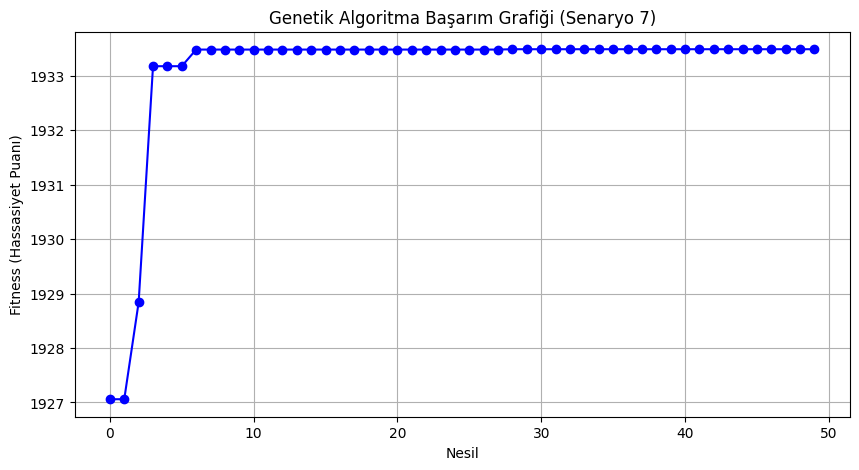

In [22]:
# --- ÇALIŞTIRMA VE GRAFİK ---
en_iyi_birey, gecmis = genetic_algorithm()

print("\n" + "="*50)
print(f"🏆 EN İYİ SONUÇ (Senaryo 7: Numune Karışımı)")
print(f"   Reaktif A (x1): %{en_iyi_birey[0]:.4f}")
print(f"   Reaktif B (x2): %{en_iyi_birey[1]:.4f}")
print(f"   Toplam Oran   : %{en_iyi_birey[0] + en_iyi_birey[1]:.2f} (<= 100 olmalı)")
print(f"   Maksimum Skor : {fitness(en_iyi_birey):.4f}")
print("="*50)

# Grafik çiz
plt.figure(figsize=(10, 5))
plt.plot(gecmis, marker='o', linestyle='-', color='b')
plt.title('Genetik Algoritma Başarım Grafiği (Senaryo 7)')
plt.xlabel('Nesil')
plt.ylabel('Fitness (Hassasiyet Puanı)')
plt.grid(True)

# --- DÜZELTME BURADA ---
# Y eksenindeki bilimsel gösterimi (e3 vb.) kapatır, normal sayı yazar.
plt.ticklabel_format(useOffset=False, style='plain', axis='y')
# -----------------------

plt.show()